In [2]:
import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
from carbon_math import carbon_flux
import xesmf as xe
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xesmf as xe
client = Client()
client

<Client: 'tcp://127.0.0.1:34745' processes=5 threads=5, memory=32.21 GB>

In [2]:
def cut_aco2():
    BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)
    BGC_monthly['xt_ocean']=BGC_monthly['xt_ocean']+360
    print(str(BGC_monthly.stf10.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20)).nbytes/1e9) + ' GB')
    co2_flux=BGC_monthly.stf10.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20))
    co2_flux=(co2_flux/1000)*86400 #mmol/s to mol/day
    co2_flux=co2_flux*-12 #to grams (And convert to ocean minus air not air minus sea. )
    co2_flux=co2_flux.rename({'xt_ocean':'lon','yt_ocean':'lat'})
    
    co2_flux['time']=np.array(co2_flux.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    co2_flux=co2_flux.sel(time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01')))
    
    co2_flux.to_netcdf('/scratch1/pit071/CAFE60/CO2flux_anth/eqpac.nc')

In [348]:
def cut_eq_vars():
    BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)
    BGC_monthly['xt_ocean']=BGC_monthly['xt_ocean']+360
    BGC_monthly=BGC_monthly.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20))
    BGC_monthly=BGC_monthly.rename({'xt_ocean':'lon','yt_ocean':'lat'})
    selected=BGC_monthly[['stf10','pprod_gross_2d','export_prod']]#,'phy']]
    
    selected['stf10']=((selected['stf10']/1000)*86400)*-12 #mmol/s to mol/day
    selected['pprod_gross_2d']=(selected['pprod_gross_2d']*6.625*12*86400)/1000
    selected['export_prod']=(selected['export_prod']*6.625*12*86400)/1000
    
    selected['time']=np.array(selected.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    selected=selected.sel(time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01')))
    
    print(str(selected.nbytes/1e9) + ' GB')
    selected.to_netcdf('/scratch1/pit071/CAFE60/eqpac_BGC.nc')

In [314]:
def proc_landschutzer():
    #Load and process landschutzer data
    landschutzer_CO2=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/spco2_MPI-SOM_FFN_v2020.nc')
    landschutzer_CO2= landschutzer_CO2.assign_coords(lon=(landschutzer_CO2.lon % 360)).roll(lon=(landschutzer_CO2.dims['lon']),roll_coords=False).sortby('lon')		#EPIC 1 line fix for the dateline problem.
    landschutzer_CO2=landschutzer_CO2.sel(lon=slice(120,290),lat=slice(-20,20)).fgco2_smoothed/365 #From per to per day
    landschutzer_CO2=landschutzer_CO2*12 #to grams
    landschutzer_CO2['time']=landschutzer_CO2['time'].astype('datetime64[M]')

    #Regrid
    regridder = xe.Regridder(landschutzer_CO2, CAFE_CO2_flux_anth.stf10, 'bilinear',reuse_weights=True)
    landschutzer_CO2=regridder(landschutzer_CO2)
    landschutzer_CO2.to_netcdf('/scratch1/pit071/carbon_data_ch2/landshutzer_regrid.nc')

In [8]:
def proc_landschutzer_old():
    #Load and process landschutzer data
    landschutzer_CO2=xr.open_dataset('/OSM/CBR/OA_DCFP/work/mat236/obs/spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc')
    landschutzer_CO2= landschutzer_CO2.assign_coords(lon=(landschutzer_CO2.lon % 360)).roll(lon=(landschutzer_CO2.dims['lon']),roll_coords=False).sortby('lon')		#EPIC 1 line fix for the dateline problem.
    landschutzer_CO2=landschutzer_CO2.sel(lon=slice(120,290),lat=slice(-20,20)).fgco2_clim/365 #From per to per day
    landschutzer_CO2=landschutzer_CO2*12 #to grams
    #landschutzer_CO2['time']=landschutzer_CO2['time'].astype('datetime64[M]')

    #Regrid
    regridder = xe.Regridder(landschutzer_CO2, CAFE_CO2_flux_anth.stf10, 'bilinear',reuse_weights=True)
    landschutzer_CO2=regridder(landschutzer_CO2)
    landschutzer_CO2.to_netcdf('/scratch1/pit071/carbon_data_ch2/landshutzer_old_regrid.nc')


In [59]:
ls /OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/

adic/            fe/              stf07/          surface_o2/
alk/             no3/             stf10/          surface_phy/
caco3/           o2/              st_ocean/       surface_zoo/
caco3_sediment/  paco2/           surface_adic/   time/
det/             pco2/            surface_alk/    total_aco2_flux/
det_sediment/    phy/             surface_caco3/  total_co2_flux/
dic/             pprod_gross/     surface_det/    xt_ocean/
ensemble/        pprod_gross_2d/  surface_dic/    yt_ocean/
export_inorg/    scalar_axis/     surface_fe/     zoo/
export_prod/     stf03/           surface_no3/


In [60]:
dat=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)

In [ ]:
dat

In [ ]:
#rm /scratch1/pit071/CAFE60/CO2flux_anth/eqpac1.nc
#CAFE_CO2_flux_anth.close()

In [3]:
#client.restart()

In [4]:
#mkdir /scratch1/pit071/CAFE60/CO2flux_anth #Use shell to make a folder
#cut_aco2()
#cut_eq_vars()
#proc_landschutzer()

In [3]:
#Open CAFE60 processed data
CAFE_CO2_flux_anth=xr.open_dataset('/scratch1/pit071/CAFE60/eqpac_BGC.nc')

#Open Landshutzer data
landschutzer_CO2=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/landshutzer_regrid.nc').fgco2_smoothed
old_land_clim=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/landshutzer_old_regrid.nc')

In [3]:
#Look at them
CAFE_CO2_flux_anth

<xarray.Dataset>
Dimensions:         (ensemble: 96, lat: 98, lon: 170, time: 456)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * time            (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
Data variables:
    stf10           (time, ensemble, lat, lon) float64 ...
    pprod_gross_2d  (time, ensemble, lat, lon) float64 ...
    export_prod     (time, ensemble, lat, lon) float64 ...
Attributes:
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    description:             CAFE coupled ocean-atmosphere-seaice reanalysis ...
    enkf-c_source:           EnKF version 1.92.4
    ens_member_number:       1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...
    experiment_start_date:   19600101
    filename:                ocean_bgc_month.zarr
    forecast_name:           not applicable
    further_info_url:        https://research.csiro.au/dfp/
    grid_tile:               1
    grid_type:               mosaic
    institution:             CSIRO CAFE
    licence:                 ### To be advised ###
    metadata_description:    \n\tEach of the metadata keys added via the CAFE...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [4]:
landschutzer_CO2

<xarray.DataArray 'fgco2_smoothed' (time: 456, lat: 98, lon: 170)>
[7596960 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Attributes:
    regrid_method:  bilinear

Text(0.5, 1.0, 'CAFE CO2 flux Ensemble 1')

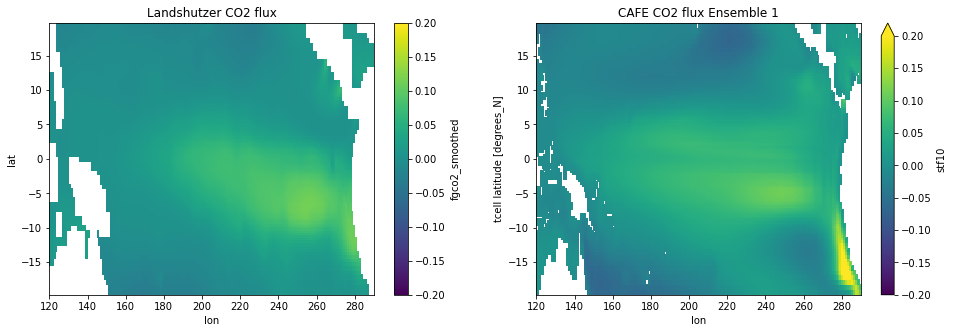

In [43]:
#Plot Landshutzer
plt.figure(figsize=(16,5))

plt.subplot(121)
(landschutzer_CO2.mean(dim='time')).plot(vmin=-.2,vmax=0.2)
plt.title('Landshutzer CO2 flux')

#Plot Cafe
plt.subplot(122)
(CAFE_CO2_flux_anth.sel(ensemble=1).mean(dim='time').stf10).plot(vmin=-.2,vmax=0.2)
plt.title('CAFE CO2 flux Ensemble 1')

/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'color'
  primitive = ax.contour(x, y, z, **kwargs)
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'color'
  primitive = ax.contour(x, y, z, **kwargs)


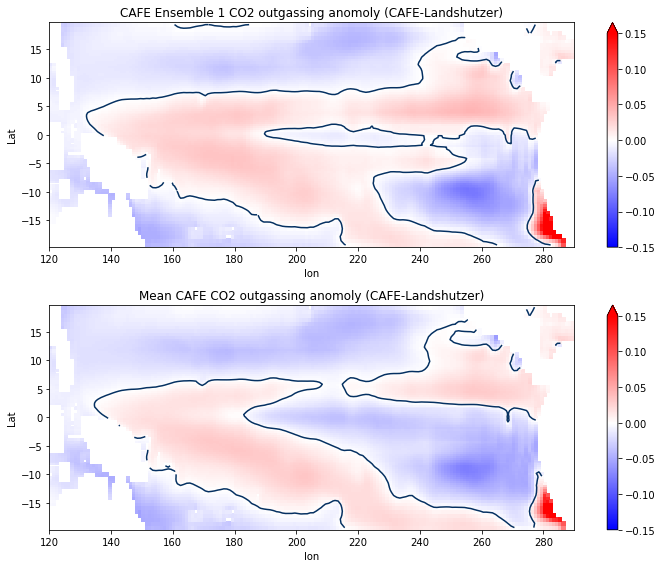

In [31]:
#Look at the difference between ensemble 1 and landschutzer
plt.figure(figsize=(10,8))
plt.subplot(211)
((CAFE_CO2_flux_anth.sel(ensemble=1).mean(dim='time').stf10)-landschutzer_CO2.mean(dim='time')).plot(vmin=-0.15,vmax=0.15,cmap='bwr')
((CAFE_CO2_flux_anth.sel(ensemble=1).mean(dim='time').stf10)-landschutzer_CO2.mean(dim='time')).plot.contour(levels=[0],color='k')
plt.title('CAFE Ensemble 1 CO2 outgassing anomoly (CAFE-Landshutzer)')
#Plot the difference between the model mean and landschutzr
plt.ylabel('Lat')


plt.subplot(212)
(CAFE_CO2_flux_anth.stf10.mean(dim=['time','ensemble'])-landschutzer_CO2.mean(dim='time')).plot(vmin=-0.15,vmax=0.15,cmap='bwr')
(CAFE_CO2_flux_anth.stf10.mean(dim=['time','ensemble'])-landschutzer_CO2.mean(dim='time')).plot.contour(levels=[0],color='k')
plt.title('Mean CAFE CO2 outgassing anomoly (CAFE-Landshutzer)')
plt.ylabel('Lat')
plt.tight_layout()

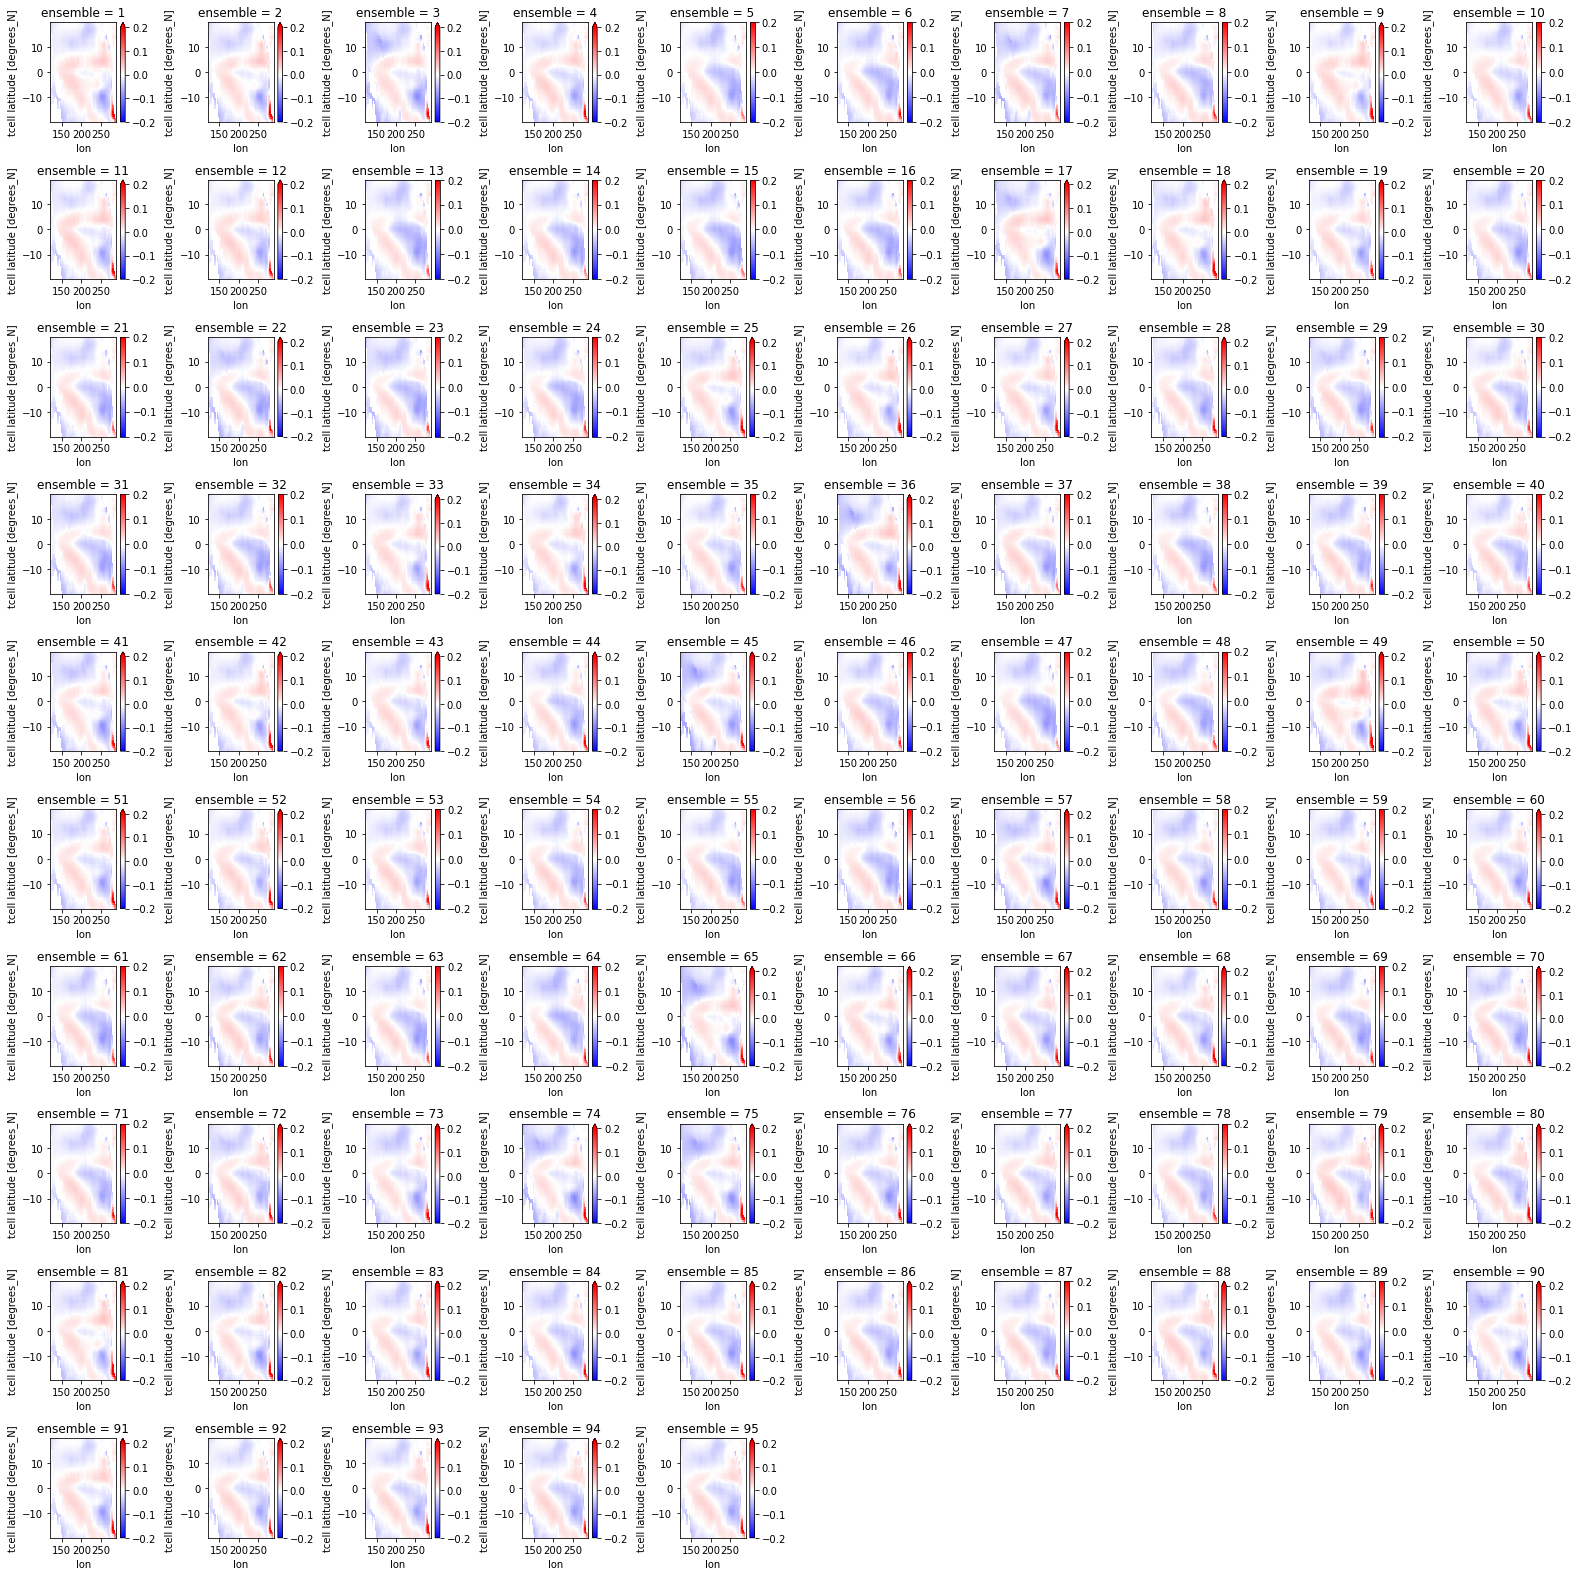

In [44]:
#Anomaly from Obs
#An anoying plot but a good start
#Basically, how do the models vary from the landschutzer 'truth'
plt.figure(figsize=(22,22))
for i in np.arange(1,96):
    plt.subplot(10,10,i)
    (CAFE_CO2_flux_anth.sel(ensemble=i).mean(dim='time').stf10-landschutzer_CO2.mean(dim='time')).plot(vmin=-0.2,vmax=0.2,cmap='bwr')

plt.tight_layout()    
plt.show()

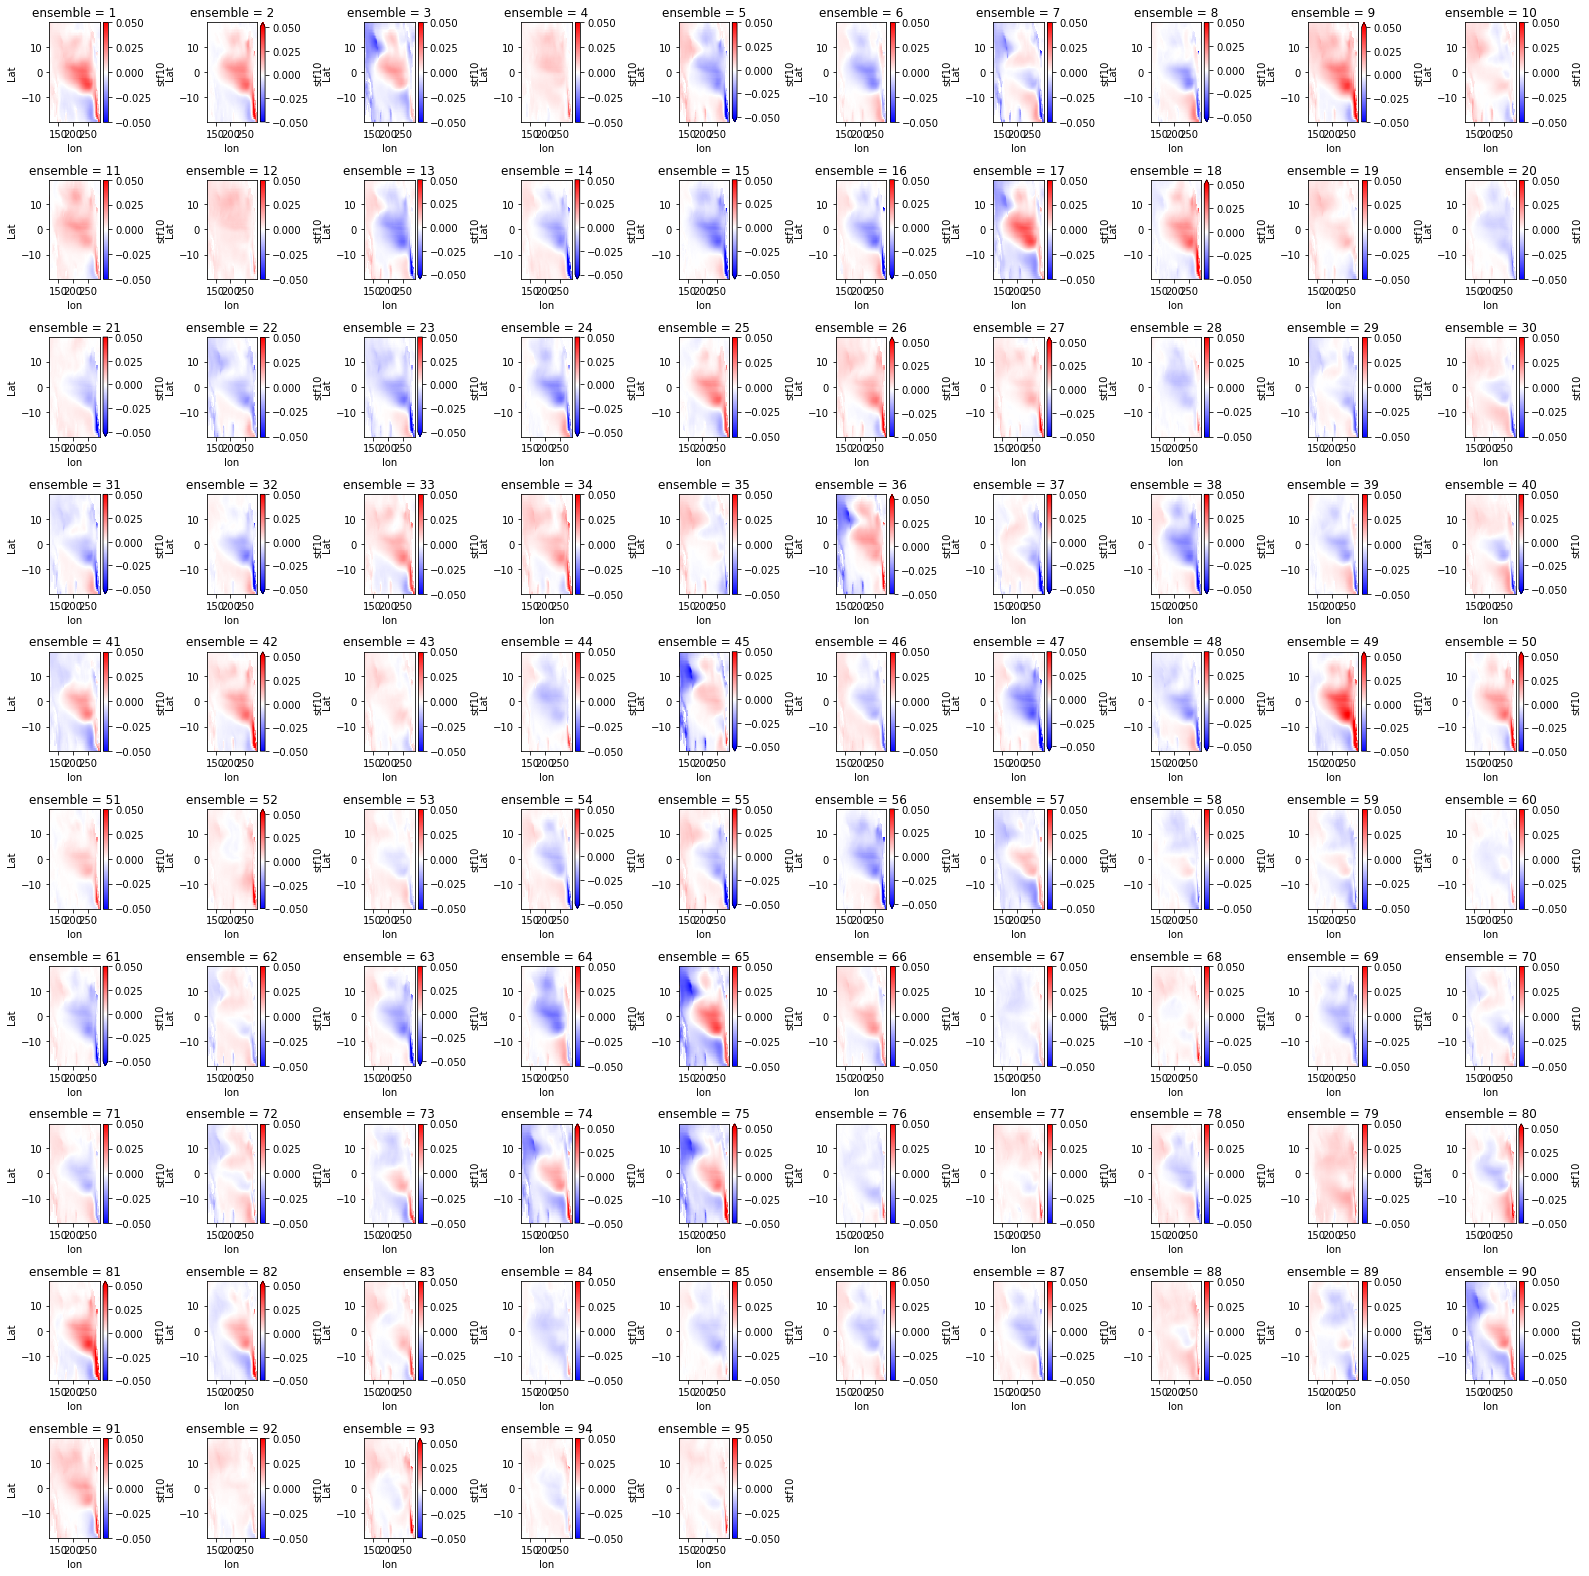

In [45]:
#Anomaly from model
#Ok they all look the same. How about we look at the difference from the mean model. 
model_mean=CAFE_CO2_flux_anth.mean(dim=['ensemble','time']).stf10
plt.figure(figsize=(22,22))
for i in np.arange(1,96):
    ax=plt.subplot(10,10,i)
    (CAFE_CO2_flux_anth.sel(ensemble=i).mean(dim='time').stf10-model_mean).plot(vmin=-0.05,vmax=0.05,cmap='bwr')
    ax.set_ylabel('Lat')
plt.tight_layout()    
plt.show()

Text(0, 0.5, 'Air-Sea (outgoing) gC/m2/day')

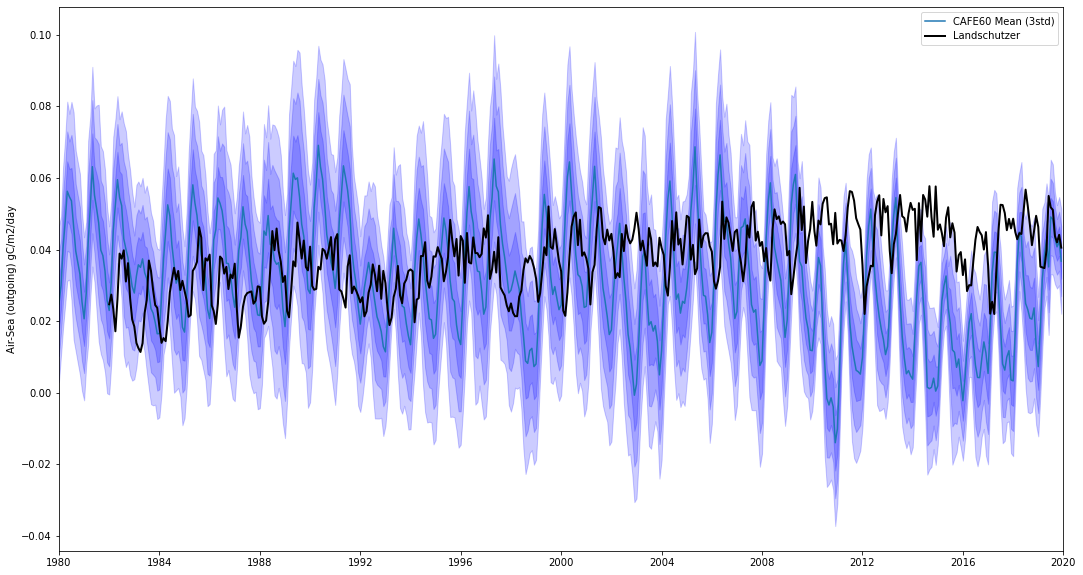

In [54]:
#Ok lets calculate the mean and std for each of the models. 
latlon=[-15,15,150,275]
cafe_co2_std=CAFE_CO2_flux_anth.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
cafe_co2_mean=CAFE_CO2_flux_anth.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
land_co2_std=landschutzer_CO2.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
land_co2_mean=landschutzer_CO2.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])

err=cafe_co2_mean.std(dim='ensemble')
m=cafe_co2_mean.mean(dim='ensemble')

plt.figure(figsize=(18,10))
plt.plot(m.time,m.stf10)
plt.fill_between(err.time,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
plt.fill_between(err.time,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
plt.fill_between(err.time,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

plt.plot(land_co2_mean.time,land_co2_mean,c='k',linewidth=2)
plt.legend(['CAFE60 Mean (3std)','Landschutzer'])
plt.xlim(['1980-01-01','2020-01-01'])
plt.ylabel('Air-Sea (outgoing) gC/m2/day')
plt.title('CO2 flux comparisons')

Text(0.5, 1.0, 'CO2 flux for 96 ensemble members in gC/m2/day: [[-15, 15, 225, 250]]')

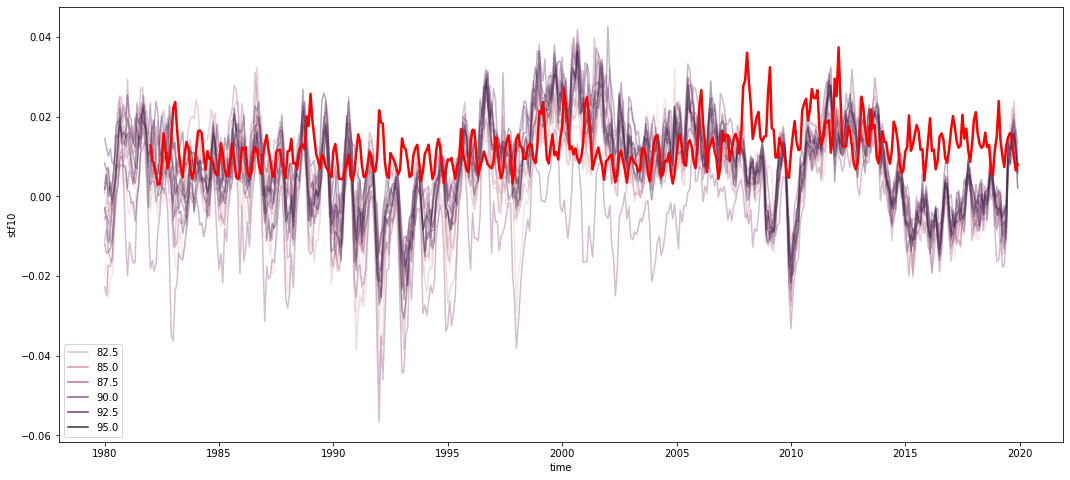

In [374]:
#A different method but not as nice. Original seaborn method. Keeping it for something different. 

cafe_co2_pd=cafe_co2_mean.stf10.T.to_dataframe().stf10.reset_index()
land_co2_pd=land_co2_mean.to_dataframe().reset_index()

plt.figure(figsize=(18,8))
palette = sns.color_palette("mako_r", 96)
sns.lineplot(data=cafe_co2_pd.where(cafe_co2_pd.ensemble>80),x='time',y='stf10',hue='ensemble',alpha=0.4, estimator='mean', ci=95)
sns.lineplot(data=land_co2_pd,x='time',y='fgco2_smoothed',color='red',linewidth=2.5)
ax.set_title('CO2 flux for 96 ensemble members in gC/m2/day: '+str(locs))

/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Whole EqPac : -32.116359643588986% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


SouthEast EqPac : 108.94881559919986% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


NorthEast EqPac : -30.706586087810063% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


All East EqPac : -5.589238208228077% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Central EqPac : -2.494964867879411% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Dateline EqPac : 6.923205016571456% err


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


FarWest EqPac : -44.45912426194419% err


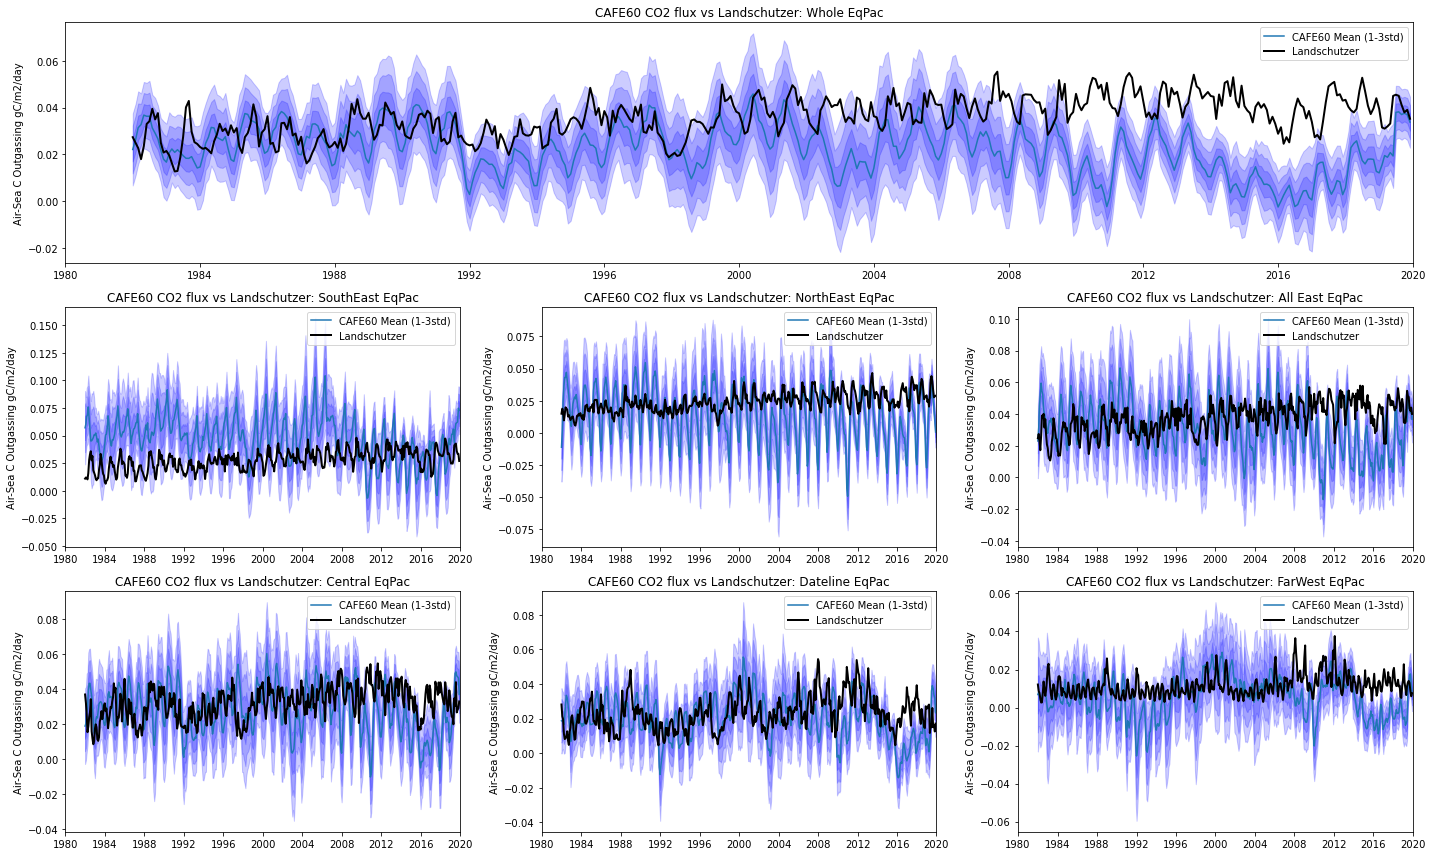

<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 7)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3 4 5 6
Data variables:
    percenterr   (region, ensemble) float64 -10.34 -12.49 ... -17.51 -28.37
    bias         (region, ensemble) float64 -0.005173 -0.006821 ... -0.004431
    mae          (region, ensemble) float64 0.01146 0.01315 ... 0.01021 0.01001
    region_name  (region) <U15 'Whole EqPac' ... 'FarWest EqPac'


In [41]:
#Ok first big plot. Regionality to look at the timeseries and see how they perform

labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    cafe_co2_std=CAFE_CO2_flux_anth.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean=CAFE_CO2_flux_anth.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    land_co2_std=landschutzer_CO2.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    land_co2_mean=landschutzer_CO2.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])

    err=cafe_co2_mean.std(dim='ensemble')
    m=cafe_co2_mean.mean(dim='ensemble')
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m.stf10)
    ax.fill_between(err.time.values,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

    ax.plot(land_co2_mean.time,land_co2_mean,c='k',linewidth=2)
    ax.legend(['CAFE60 Mean (1-3std)','Landschutzer'])
    ax.set_xlim(['1980-01-01','2020-01-01'])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])

    
    #Calculate biases
    perc_err=(((cafe_co2_mean.stf10-land_co2_mean)/land_co2_mean)*100).mean(dim='time')
    bias=(cafe_co2_mean.stf10-land_co2_mean).mean(dim='time')
    mae=np.abs(cafe_co2_mean.stf10-land_co2_mean).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_err=xr.concat(all_err,dim='region')
regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
plt.tight_layout()
plt.show()
print(regional_err)

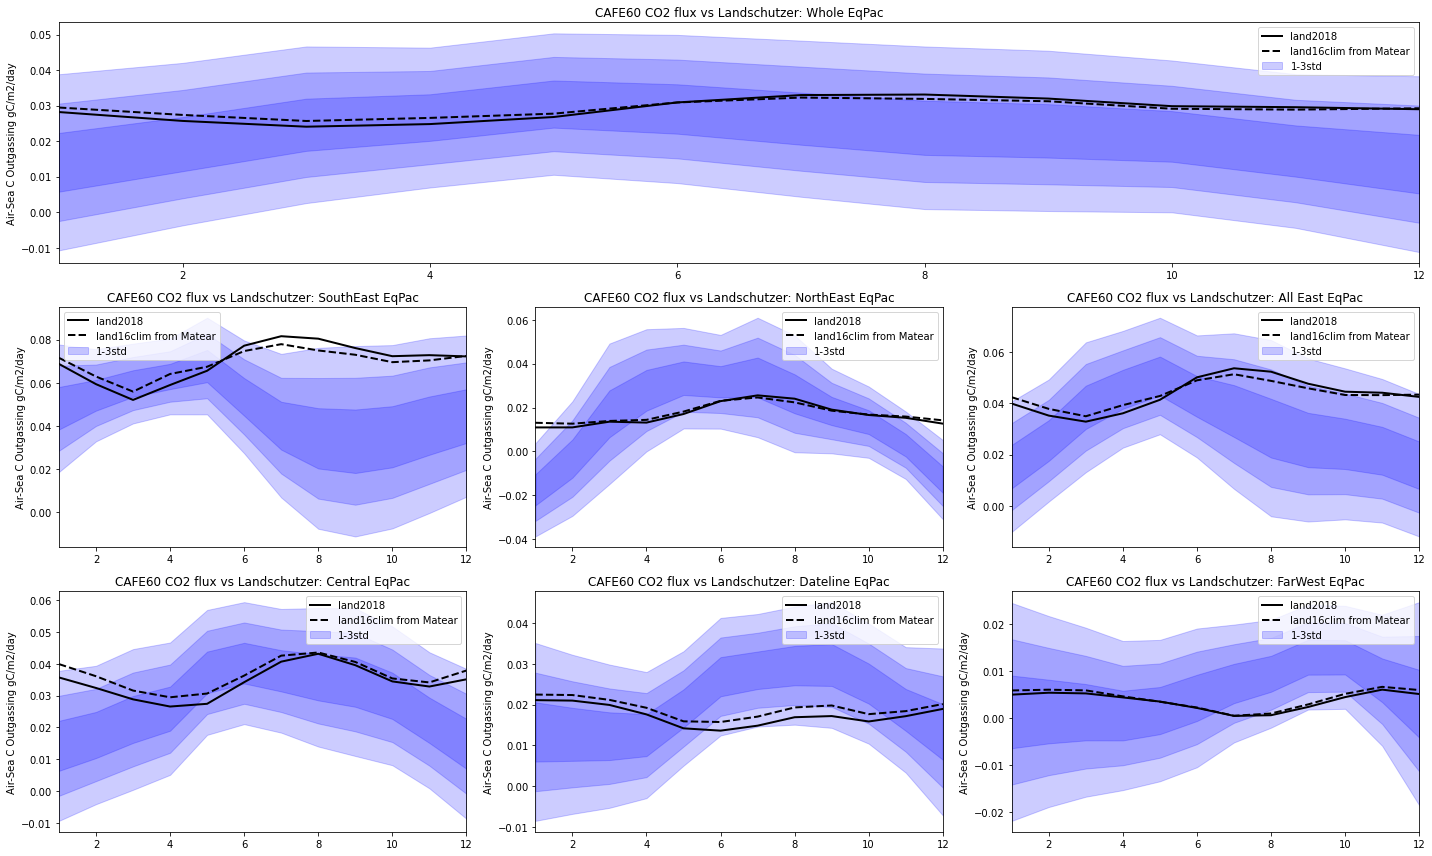

In [24]:
#They don't line up very well so lets check the seasonality

labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

for i,latlon in enumerate(locs):
    cafe_seasonality=CAFE_CO2_flux_anth.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).stf10.groupby('time.month').mean()
 
    land_seasonality=landschutzer_CO2.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).groupby('time.month').mean().mean(dim=['lat','lon'])
 

    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon'])
    m=cafe_seasonality.mean(['lat','lon','ensemble'])
    
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')
    

    ax.plot(land_seasonality.month,land_seasonality,c='k',linewidth=2)
   
    olc=old_land_clim.fgco2_clim.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    olc['monthclim']=olc['monthclim']+1
    ax.plot(olc.monthclim,olc,c='k',linewidth=2,linestyle='--')
    
    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
        
        
    ax.set_xlim([1,12])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])
    ax.legend(['land2018','land16clim from Matear','1-3std'])
plt.tight_layout()

    
  
    


In [ ]:
#Ok the seasonality is terrible. Hmm. Its literally upside down .........

In [46]:
#How can we look at ENSO? Can we use the raw months used previously... Probably need to calculate the SOI for each model....


In [47]:
r_err=xr.open_dataset('/scratch1/pit071/CO2_flux_error.nc')

In [48]:
r_err

<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 7)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3 4 5 6
Data variables:
    percenterr   (region, ensemble) float64 ...
    bias         (region, ensemble) float64 ...
    mae          (region, ensemble) float64 ...
    region_name  (region) object ...

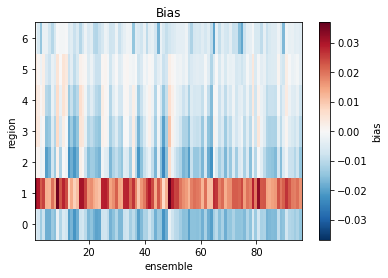

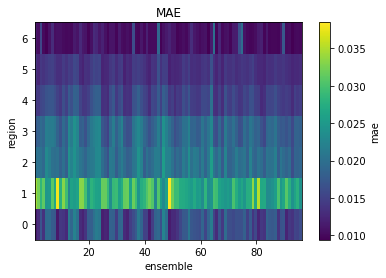

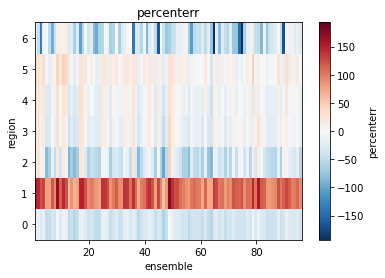

In [67]:
r_err.bias.plot(),plt.title('Bias')
plt.show()
r_err.mae.plot(),plt.title('MAE')
plt.show()
r_err.percenterr.plot(),plt.title('percenterr')
plt.show()
#Ok so CAFE overestimates the  North East way more than it should be. Something to do with the N-S gradient in the east Pacific not being represented very well?


Text(0.5, 1.0, 'Percent error relative to landshutzer for different regions')

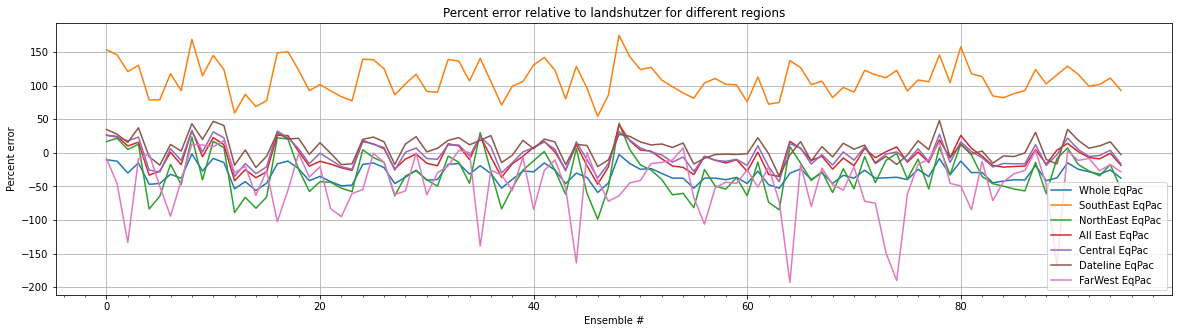

In [58]:

plt.figure(figsize=(20,5))
ax=plt.subplot(111)
ax.plot(r_err.percenterr.T)
plt.legend(r_err.region_name.values)
ax.grid()
ax.xaxis.set_minor_locator(MultipleLocator(2))
plt.xlabel('Ensemble #')
plt.ylabel('Percent error')
plt.title('Percent error relative to landshutzer for different regions')

Text(0.5, 1.0, 'Percent error relative to landshutzer for different regions')

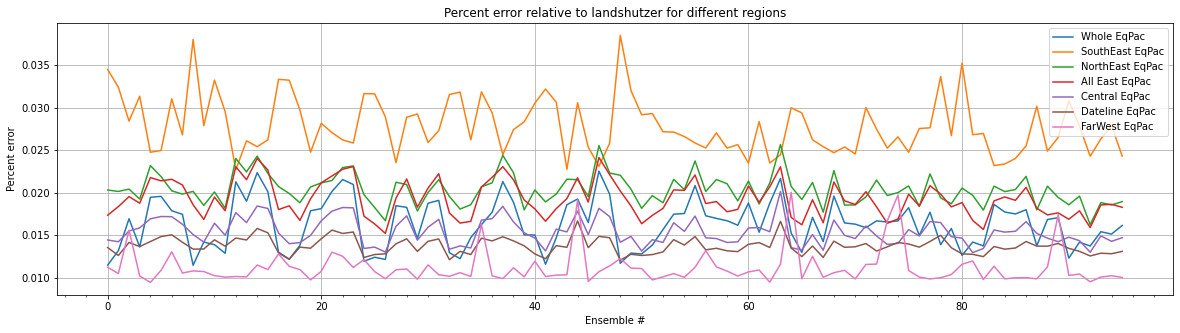

In [59]:

plt.figure(figsize=(20,5))
ax=plt.subplot(111)
ax.plot(r_err.mae.T)
plt.legend(r_err.region_name.values)
ax.grid()
ax.xaxis.set_minor_locator(MultipleLocator(2))
plt.xlabel('Ensemble #')
plt.ylabel('Mean Absolute error')
plt.title('Mean Absolute error relative to landshutzer for different regions')

Text(0.5, 1.0, 'Bias relative to landshutzer for different regions')

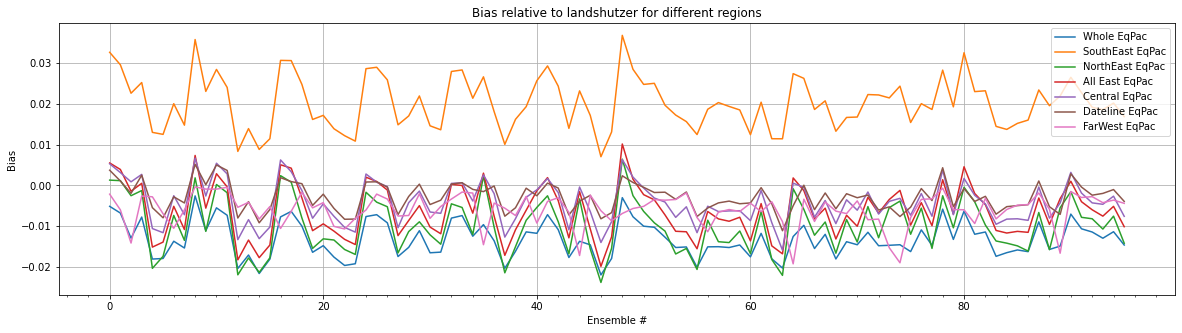

In [61]:

plt.figure(figsize=(20,5))
ax=plt.subplot(111)
ax.plot(r_err.bias.T)
plt.legend(r_err.region_name.values)
ax.grid()
ax.xaxis.set_minor_locator(MultipleLocator(2))
plt.xlabel('Ensemble #')
plt.ylabel('Bias')
plt.title('Bias relative to landshutzer for different regions')

In [ ]:
#Ok need some more thinking before moving onto these variables.


In [115]:
#NPP
dat=xr.open_dataset('/scratch1/pit071/CAFE60/eqpac_BGC.nc')
dat['time']=np.array(dat.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
primary=dat.pprod_gross_2d
primary_mean_2d=primary.mean(dim=['time','ensemble'])
primary_mean=primary.mean(dim=['ensemble'])
primary_std=primary.std(dim=['ensemble'])

export=dat.export_prod
export_mean=export.mean(dim=['time','ensemble'])

<ipython-input-115-a2f8c05ec051>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dat['time']=np.array(dat.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [148]:
#Obs Data
NPP_sat_CAFE=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/carbon/avg_npp_rg_cafe.nc')/1000
fratios=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/carbon/fratios.nc')
new_production=(cafe*fratios.laws2011a).avg_npp/1000

In [114]:
primary.time

<xarray.DataArray 'time' (time: 720)>
array([cftime.DatetimeJulian(1960, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeJulian(1960, 2, 15, 12, 0, 0, 0),
       cftime.DatetimeJulian(1960, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeJulian(2019, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [99]:
primary_mean_2d.nbytes/1e9

0.00013328

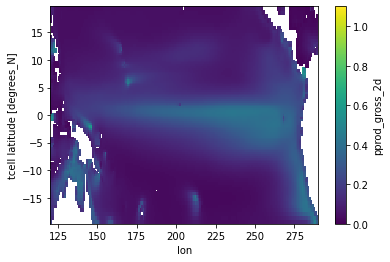

In [89]:
#MODEL NPP PLOT
primary_mean_2d.plot(vmin=0,vmax=1.1)

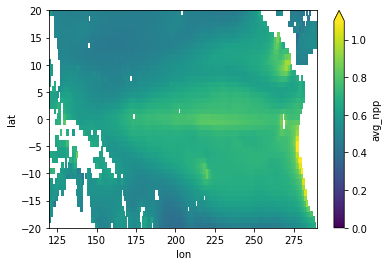

In [143]:
#COnfusing should change this to 'Satellite NPP (CAFE algorithm haha)'
(NPP_sat_CAFE.mean(dim='time')).avg_npp.plot(vmin=0,vmax=1.1) #mgC/day
plt.show()

In [151]:
land_co2_mean.values

array([0.07451623, 0.07085969, 0.06608291, 0.06264424, 0.06525498,
       0.0707434 , 0.07144363, 0.07108284, 0.06727351, 0.06982681,
       0.07629354, 0.087553  , 0.09245205, 0.09155046, 0.08608676,
       0.08614666, 0.08951579, 0.09173999, 0.0913268 , 0.0870156 ,
       0.0793154 , 0.07754592, 0.08062526, 0.09023592, 0.09695911,
       0.09572831, 0.09297854, 0.09119106, 0.09227069, 0.09441654,
       0.09282784, 0.08387648, 0.07843567, 0.07678742, 0.07925111,
       0.08653071, 0.09157225, 0.09070301, 0.08557998, 0.08417983,
       0.08686376, 0.09029726, 0.08690144, 0.08024794, 0.0754411 ,
       0.07188295, 0.07520128, 0.08358198, 0.09084544, 0.08842847,
       0.08349339, 0.0804982 , 0.08274617, 0.08421113, 0.08326273,
       0.07638012, 0.06919985, 0.06583334, 0.07345253, 0.08209425,
       0.0866949 , 0.08453197, 0.07834601, 0.07636242, 0.0787053 ,
       0.08266561, 0.08081851, 0.07895384, 0.0771037 , 0.07507818,
       0.07655429, 0.08428545, 0.08940499, 0.08592485, 0.08113

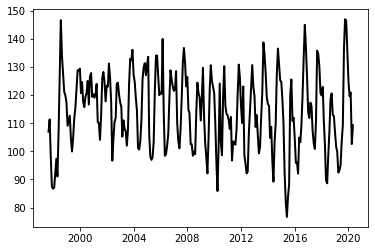

0
1
2
3
4
5
6


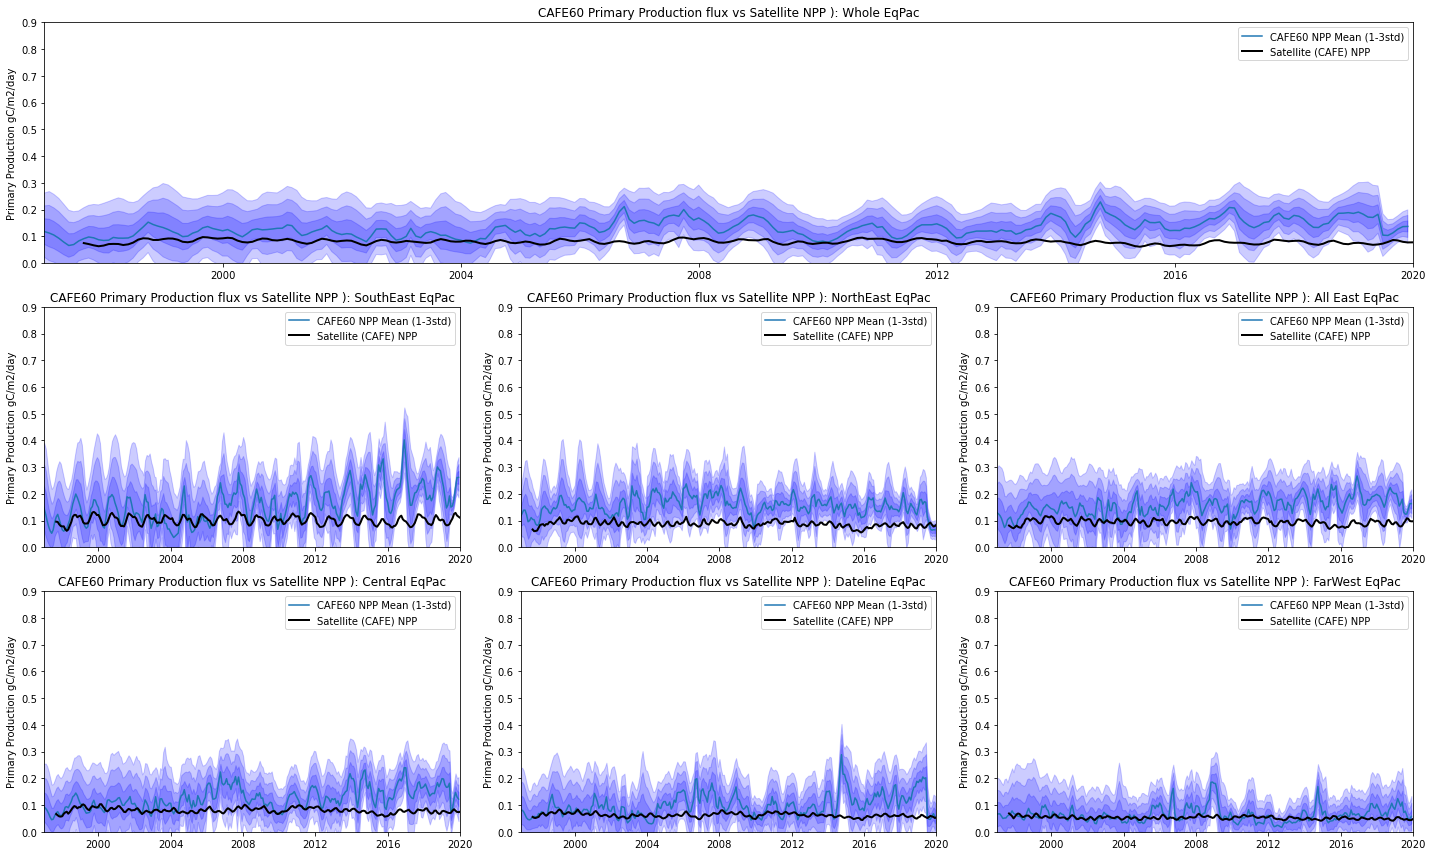

In [152]:
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

for i,latlon in enumerate(locs):
    cafe_co2_std=primary.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean=primary.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    land_co2_std=new_production.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    land_co2_mean=new_production.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])

    err=cafe_co2_mean.std(dim='ensemble')
    m=cafe_co2_mean.mean(dim='ensemble')
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m)
    ax.fill_between(err.time.values,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m+(err*3),m-(err*3),alpha=0.2,color='blue')
    ax.plot(land_co2_mean.time.values,land_co2_mean.values,c='k',linewidth=2)
    ax.legend(['CAFE60 NPP Mean (1-3std)','Satellite (CAFE) NPP'])
    ax.set_xlim(['1997-01-01','2020-01-01'])
    ax.set_ylim([0,0.9])
    ax.set_ylabel('Primary Production gC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 Primary Production flux vs Satellite NPP ): '+labels[i])
    print(i)
plt.tight_layout()

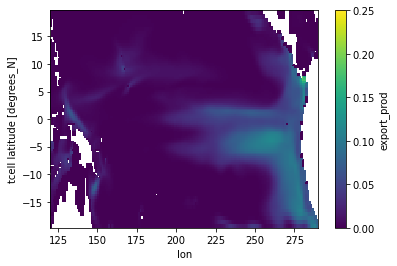

In [88]:
export_mean.plot(vmin=0,vmax=0.25)

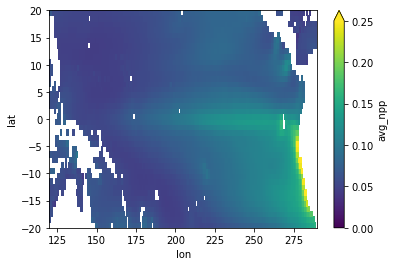

In [86]:
(new_production.mean(dim='time')/1000).plot(vmin=0,vmax=0.25) #mgC/day
plt.show()

In [147]:
BGC_monthly

<xarray.Dataset>
Dimensions:          (ensemble: 96, scalar_axis: 1, st_ocean: 50, time: 720, xt_ocean: 360, yt_ocean: 300)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
  * xt_ocean         (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean         (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
Data variables:
    adic             (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    caco3_sediment   (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    det              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    det_sediment     (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    dic              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    export_inorg     (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    export_prod      (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    fe               (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    no3              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    o2               (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    paco2            (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    pco2             (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    phy              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    pprod_gross      (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    pprod_gross_2d   (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    stf03            (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    stf07            (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    stf10            (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_adic     (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_alk      (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_caco3    (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_det      (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_dic      (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_fe       (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    surface_no3      (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<ch

In [146]:
BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)

In [378]:

pprod=BGC_monthly.pprod_gross_2d

pprod=pprod.sel(xt_ocean=slice(-220,-80),yt_ocean=slice(-20,20)).mean(dim=['time','ensemble'])
pprod.plot()


<xarray.Dataset>
Dimensions:         (ensemble: 96, time: 720, xt_ocean: 360, yt_ocean: 300)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * time            (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean        (yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77
Data variables:
    stf10           (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    pprod_gross_2d  (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
Attributes:
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    description:             CAFE coupled ocean-atmosphere-seaice reanalysis ...
    enkf-c_source:           EnKF version 1.92.4
    ens_member_number:       1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...
    experiment_start_date:   19600101
    filename:                ocean_bgc_month.zarr
    forecast_name:           not applicable
    further_info_url:        https://research.csiro.au/dfp/
    grid_tile:               1
    grid_type:               mosaic
    institution:             CSIRO CAFE
    licence:                 ### To be advised ###
    metadata_description:    \n\tEach of the metadata keys added via the CAFE...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [ ]:
export=BGC_monthly.export_prod
export_flux=((export*6.625*12*86400)/1000) #So *6.625 to work out carbon moles, * 12 to grams and units are seconds so calculate to a day and 1000 for mmol to mol. #xr.apply_ufunc(moles_to_carbon,, dask='parallelized')

In [ ]:
BGC_monthly.phy

In [95]:
BGC_monthly.phy

<xarray.DataArray 'phy' (time: 720, ensemble: 96, st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
dask.array<zarr, shape=(720, 96, 50, 300, 360), dtype=float32, chunksize=(1, 96, 3, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    cell_methods:  time: mean
    coordinates:   geolon_t geolat_t
    long_name:     phy
    units:         mmol/m^3
    valid_range:   [-1000000.0, 1000000.0]

In [94]:
chl

<xarray.DataArray 'phy' (yt_ocean: 98, xt_ocean: 140)>
dask.array<mean_agg-aggregate, shape=(98, 140), dtype=float32, chunksize=(98, 140), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -219.5 -218.5 -217.5 ... -82.5 -81.5 -80.5
  * yt_ocean  (yt_ocean) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36

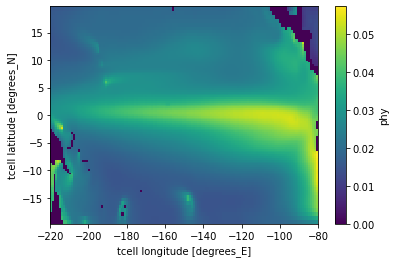

In [93]:
BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)
chl=BGC_monthly.phy.sel(st_ocean=slice(0,20)).mean(dim='time').sum(dim='st_ocean')
chl=chl.sel(xt_ocean=slice(-220,-80),yt_ocean=slice(-20,20))
chl=(chl/14)*893.51
chl=chl.mean(dim=['ensemble'])
#or chl.sel(ensemble=5)
chl.plot()
#CHLOROPHYLL

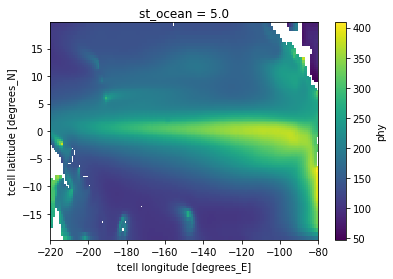

In [98]:
BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)
chl=BGC_monthly.phy.sel(st_ocean=5).mean(dim='time')
chl=chl.sel(xt_ocean=slice(-220,-80),yt_ocean=slice(-20,20))
chl=(chl)*893.51
chl=chl.mean(dim=['ensemble'])
#or chl.sel(ensemble=5)
chl.plot()
#CHLOROPHYLL

In [96]:
0.05*1000

50.0